# Problèmes aux valeurs propres

On cherche des couples $(\lambda,{\mathbf{u}})$ solutions de
${\mathbf{A}}{\mathbf{u}}=\lambda {\mathbf{u}}$
(dans ${\mathbb{R}}^n$). Pour des matrices de taille
supérieure à 4, il n'existe pas de méthode directe pour les obtenir. Si
${\mathbf{U}}$ est la matrice des vecteurs propres et
${\mathbf{\Lambda}}$ la matrice diagonale des valeurs
propres, on a :
${\mathbf{A}}{\mathbf{U}}= {\mathbf{U}}{\mathbf{\Lambda}}$.
On ordonne les valeurs propres
$\lambda_1\geqslant \lambda_2 \ldots\lambda_n$.

On rappelle au passage que les problèmes aux valeurs propres généralisées
${\mathbf{A}}{\mathbf{u}}=\lambda {\mathbf{B}}{\mathbf{u}}$ se traitent pratiquement de la même manière.




## Techniques de base

### La méthode des puissances

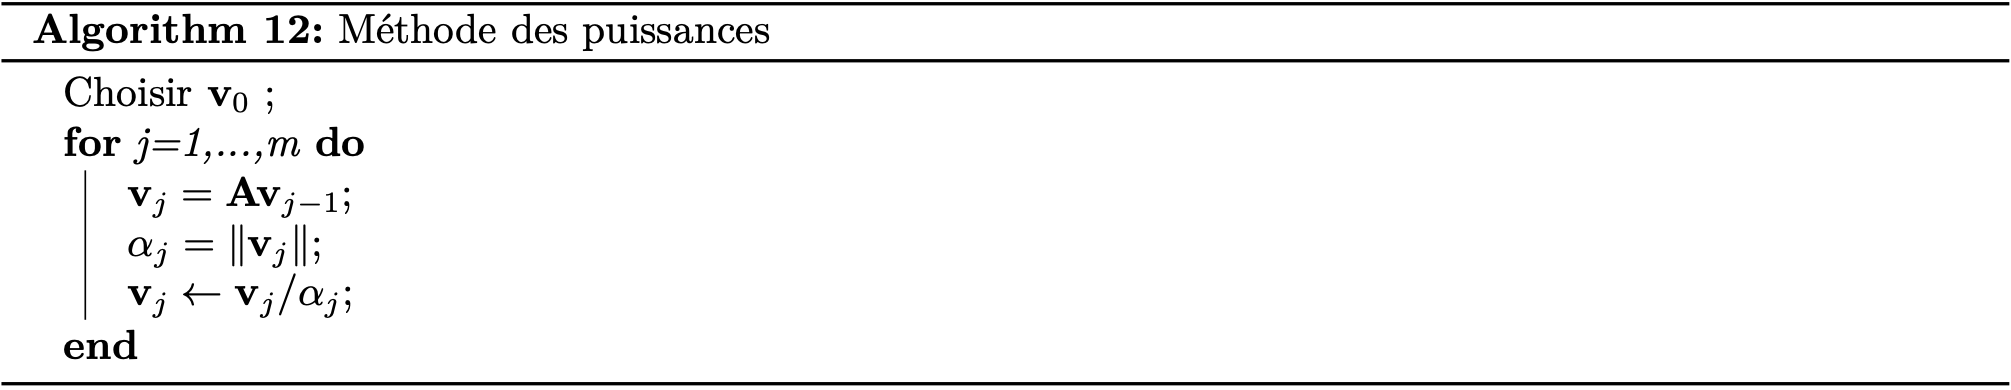

Si la plus grande valeur propre dont le sous-espace propre rencontre
${\mathbf{v}}_0$ est semi-simple alors $(\alpha_j)$ converge
vers celle-ci et ${\mathbf{v}}_{j}$ converge vers un vecteur
propre associé.

*Remarque 7.1*. Si ${\mathbf{v}}_0$ est choisi au hasard
alors la probabilité qu'il rencontre ${\mathbf{u}}_1$ est
de 1. Autrement dit
${\mathbf{v}}_0=\sum v_i{\mathbf{u}}_i$ et
$v_1\neq 0$ presque sûrement.

La convergence est d'autant plus rapide que cette valeur propre est
séparée de la seconde plus grande valeur propre. En effet, on a
décompose ${\mathbf{v_0}}$ sur la base propre
${\mathbf{v}}_0=\sum v_k{\mathbf{u}}_k$, on a :
$$\begin{aligned}
{\mathbf{A}}^m{\mathbf{v}}_0 &= \sum_k  \lambda_k^m v_k{\mathbf{u}}_k \\
&= \lambda_1^m v_1 \left({\mathbf{u}}_1 + \sum_{k>1} \left(\frac{\lambda_k}{\lambda_1}\right)^m \frac{v_k}{v_1}{\mathbf{u}}_k \right)
\end{aligned}$$ On a
$\|{\mathbf{A}}^m{\mathbf{v}}_0\|\approx \lambda_1^m v_1$,
donc
${\mathbf{A}}^m{\mathbf{v}}_0/\|{\mathbf{A}}^m{\mathbf{v}}_0\|\to{\mathbf{u}}_1$
et que le terme restant qui tend le moins vite vers 0 est de la forme
$(\lambda_2/\lambda_1)^m$.

*Remarque 7.2* (Méthode à pas multiple). Tant que les calculs
n'explosent pas, on peut se passer de l'étape de normalisation dans les
itérations. Au lieu de calculer
${\mathbf{A}}{\mathbf{v_j}}$, on calcule
${\mathbf{A}}^m{\mathbf{v_j}}$. Dans certains cas
(matrice stockée de manière distribuée), cela permet de gagner du temps
de calcul.

Implémenter cette méthode et comparer son résultat à celui donné par la fonction numpy.

In [92]:
import numpy as np
from numpy import linalg as la

n=10
# A est une matrice symétrique, définie et positive
A = np.random.random((n, n))
A=A*A.transpose()+n*np.identity(n)

def puissance(A, max_iter,er_max):
    j = 0
    v0 = np.random.random(n)
    error = 1
    while j<max_iter and error > er_max:
        v = A@v0
        alpha = la.norm(v)
        v = v/alpha
        error = la.norm(v-v0)/alpha
        v0 = v
        j+=1
    return alpha,v, error, j

max_iter = 1000
precision = 1e-10

lambda1, v1 = la.eig(A)
lamb, v, error, n_iter = puissance(A,max_iter, precision)
index = np.argmax(lambda1[0])
if n_iter<max_iter:
    print("Precision Reached in", n_iter, 'Iterations')
else:
    print("Precision Not Reached\nLast Iteration", n_iter, '\nLast Error', error)

# Assertions
assert(np.allclose(lambda1[index], lamb))
print("\nEigenValue:")
print('Numpy Solution:',round(lambda1[index], 3))
print('Puissance Solution:',round(lamb,3))

'''Eigen vectors'''
print("\nEigenvector:")

print('Numpy Solutions:\n',v1[:,index])
print('Puissance Solutions:\n',v)


'''The eigenvectors can have opposite signs in which case the solution still remains valid since this is just a normalization effect'''

Precision Reached in 109 Iterations

EigenValue:
Numpy Solution: 12.74
Puissance Solution: 12.74

Eigenvector:
Numpy Solutions:
 [0.48617945 0.32390021 0.209357   0.33820118 0.25905625 0.44395734
 0.2387538  0.21198969 0.14195688 0.33794198]
Puissance Solutions:
 [0.48617945 0.32390021 0.209357   0.33820119 0.25905625 0.44395733
 0.2387538  0.21198969 0.14195688 0.33794198]


'The eigenvectors can have opposite signs in which case the solution still remains valid since this is just a normalization effect'


### Méthode des puissances inverses

On suppose que la matrice ${\mathbf{A}}$ est inversible.
Cette méthode converge vers un couple (vecteur, valeur) propre associé à
la plus petite valeur propre de ${\mathbf{A}}$.

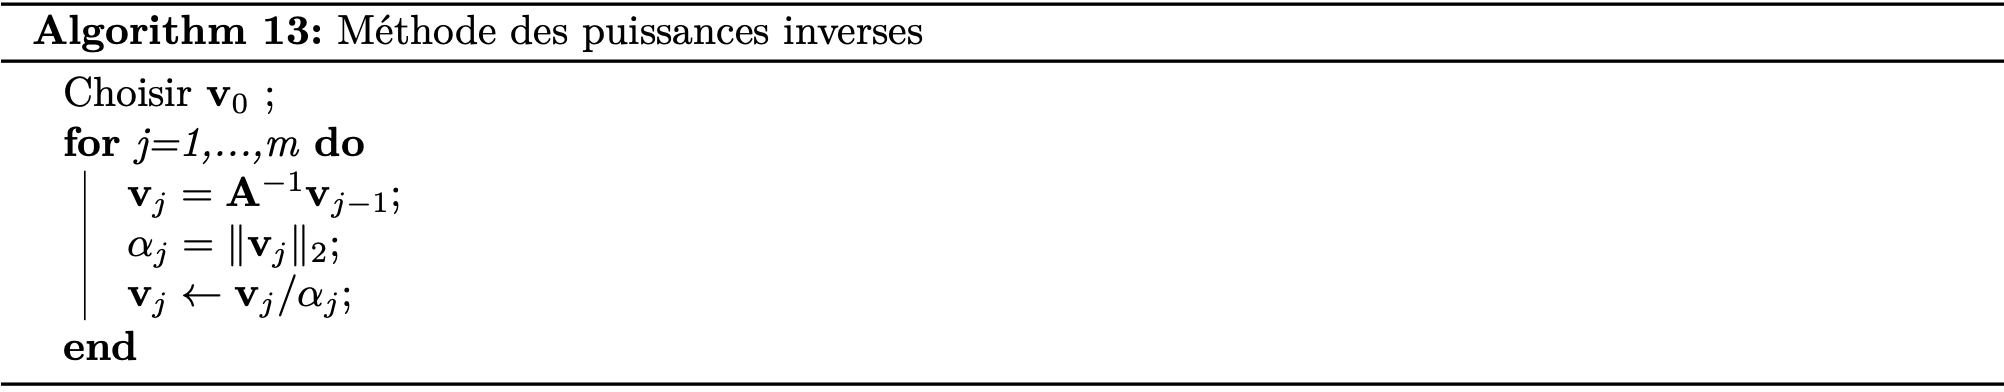

La convergence est d'autant plus rapide que la seconde plus petite
valeur propre est loin de la première.

### Méthode des puissances inverses avec décalage

Pour étudier l'intérieur du spectre d'une matrice, on décale son
origine. Soit $\sigma$ une approximation de la valeur propre à trouver.
On s'en sert de décalage (*shift*):
$({\mathbf{A}}-\sigma{\mathbf{I}})$.

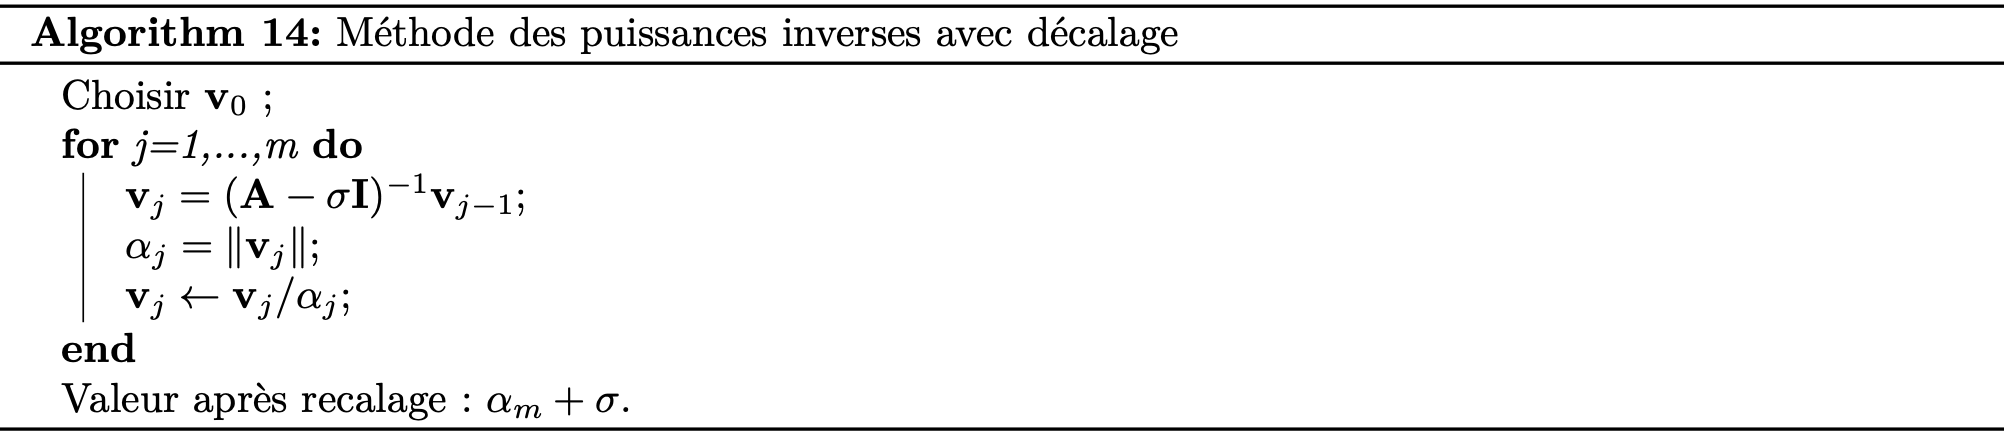

Si le décalage est proche de la valeur recherchée (et donc loin de la
seconde plus proche valeur) alors la convergence sera très rapide.



Une idée très intéressante dans le cas Hermitien est d'optimiser le
décalage à chaque itération en utilisant le quotient de Rayleigh pour
approcher la valeur propre recherchée.

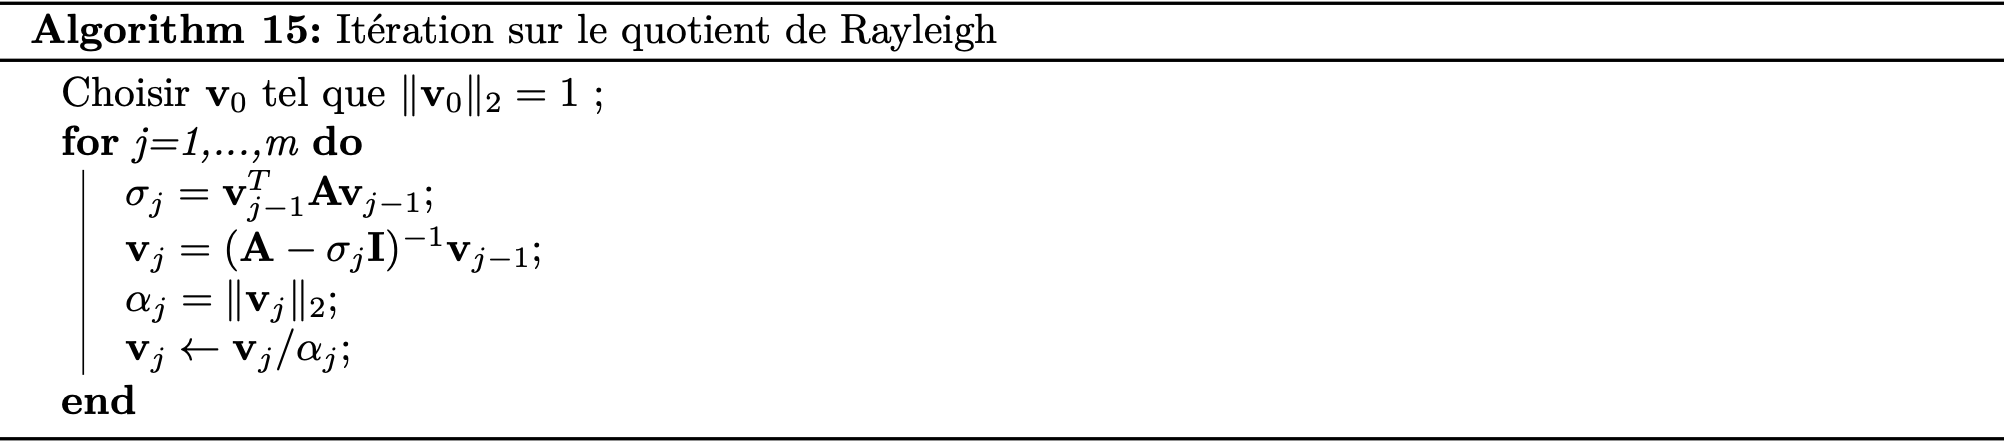


On propose d'utiliser la méthode du quotient de Rayleigh en méthode force brute pour trouver toutes les valeurs propres d'une matrice SPD. Pour cela on implément l'algorithme précédent qu'on appellera un nombre de fois suffisant pour trouver l'intégralité des valeurs propres. On comparera aux valeurs données par la fonction numpy.

In [90]:
import numpy as np
from numpy import linalg as la

n=10
# A est une matrice symétrique, définie et positive
A = np.random.random((n, n))
A=A*A.transpose()+n*np.identity(n)

def rayleigh_method(A, max_iter):
    j = 0
    n=A.shape[0]
    v0 = np.random.randn(n)
    v0 = v0/la.norm(v0,2)
    sigma = v0.T@A@v0
    for _ in range(max_iter):
        v = (la.inv(A - (sigma*np.eye(n))))@v0
        v0 = v/la.norm(v)
        sigma = v0.T@A@v0
    return v0, j

max_iter = 100
lambda1, v1 = la.eig(A)

iter = 0
sol = []
while len(np.unique(sol))<n:
    v,_ = rayleigh_method(A,max_iter)
    lamb = np.round(v.T@A@v,3)
    sol.append(lamb)
    iter += 1

# Assertions

npSol = np.unique(np.round(lambda1,3))
pSol = np.unique(np.round(sol,3))

assert(np.allclose(npSol, pSol))
print('Assertions Passed: Found the eigenvalues!\n')
print('Iterations taken:', iter)
print('\nNumpy Solution:',npSol)
print("Rayleigh Solutions:", pSol)



Assertions Passed: Found the eigenvalues!

Iterations taken: 441

Numpy Solution: [ 8.954  9.036  9.45   9.687  9.828 10.098 10.41  10.881 11.314 13.076]
Rayleigh Solutions: [ 8.954  9.036  9.45   9.687  9.828 10.098 10.41  10.881 11.314 13.076]


### Déflation

Si on a déjà calculé une valeur propre $\lambda_j$ et un vecteur propre
(à droite) associé ${\mathbf{u}}_j$, et que l'on cherche la
seconde plus proche, une solution consiste à modifier l'opérateur pour
faire disparaître cette valeur propre, une solution est la déflation de
Wielandt :
$${\mathbf{A}}_1 = {\mathbf{A}} -\sigma {\mathbf{u}}_j{\mathbf{v}}^H$$
$\sigma$ est un décalage à déterminer, ${\mathbf{v}}$ doit
juste satisfaire ${\mathbf{v}}^H{\mathbf{u}}_j=1$.
Cette déflation ne modifie pas le spectre sauf pour $\lambda$ qui est
décalé vers $\lambda_j-\sigma$. Le choix du vecteur
${\mathbf{v}}$ peut se faire selon plusieurs critères. En
pratique le choix ${\mathbf{v}}={\mathbf{u}}_j$ se
révèle quasi-optimal (dans l'optique de minimiser le conditionnement du
problème de recherche de $\lambda_{j+1}$) pour un *shift* suffisamment
grand ; un autre choix intéressant est d'utiliser
${\mathbf{v}}={\mathbf{w}}_j$ où
${\mathbf{w}}_j$ est le vecteur propre à gauche associé à
$\lambda_j$ (déflation d'Hotelling), bien sûr les deux stratégies sont
équivalentes dans le cas hermitien.

Il est possible de faire de la déflation par sous-espaces
${\mathbf{A}}_j= {\mathbf{U}}_j{\mathbf{\sigma}}{\mathbf{U}}_j^H$
où ${\mathbf{U}}_j$ est une base orthonormale de vecteurs de
Schur (vecteurs intervenant dans la trigonalisation éponyme). On peut
alors enchaîner les calculs de valeurs propres en augmentant la base de
déflation par l'orthonormalisé d'un vecteur convergé.



### Itérations par sous-espaces

Dans toutes les méthodes précédentes, il est possible de rechercher
simultanément un ensemble de (valeurs, vecteurs) propres. On parle de
méthode par sous-espace ou par bloc. On donne la version puissance
itérée. L'idée est de partir d'une famille initiale de $m$ vecteurs
orthonormaux
${\mathbf{X}}_0 = ({\mathbf{x}}_{0,0},\ldots,{\mathbf{x}}_{m,0})$,
il suffit simplement de remplacer la normalisation par une factorisation
QR.

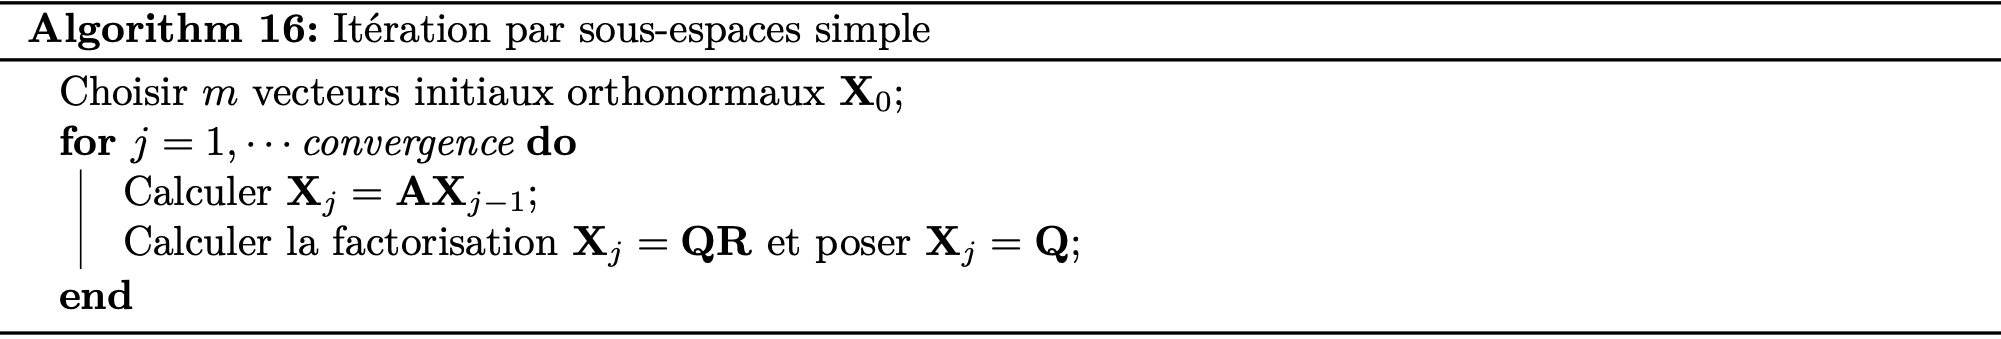

Ces méthodes permettent de converger vers des vecteurs de Schur (donc
des sous-espaces stables). On peut y appliquer toutes les variations
précédentes (déflation, shift, pas multiples). En particulier, les pas
multiples permettent d'économiser des factorisations QR.

On propose d'implémenter la méthode ci-dessus (on y ajoutera le calcul des valeurs propres), et on la comparera à la méthode proposée par numpy.

In [91]:
import numpy as np
from numpy import linalg as la
from scipy.stats import ortho_group 

n=100
# A est une matrice symétrique, définie et positive
A = np.random.random((n, n))
A=A*A.transpose()+n*np.identity(n)

def sous_espace(A, max_iter, er_max):
    X0 = ortho_group.rvs(dim=A.shape[0])
    j = 0
    error =1
    while j<max_iter and error > er_max:
        X = A@X0
        q,r = la.qr(X)
        X = q
        error = la.norm(X-X0)/la.norm(X0)
        X0 = X
        j += 1
    l = np.diag(X.T@A@X)
    return l, error, X, j
lambda1, v1 = la.eig(A)
max_iter = 1e5
er_max = 1e-6
lamb, error, v, n_iter = sous_espace(A, max_iter, er_max)

index1 = np.argsort(lambda1)
index = np.argsort(lamb)

sol1 = lambda1[index1]
sol = lamb[index]

# Assertion
assert(np.allclose(sol1, sol, 1e-4))
print("Assertion Passed! Solutions are equal\n")
print('Iterations taken:', n_iter)
print('\nNumpy:\n', sol1)
print('Sous_espaces:\n', sol)


Assertion Passed! Solutions are equal

Iterations taken: 36049

Numpy:
 [ 95.95642483  96.03623203  96.20301997  96.25006243  96.35045832
  96.52109773  96.68206893  96.76426778  96.82512228  96.9134506
  97.04310372  97.1078474   97.27397979  97.37287572  97.40303577
  97.50488697  97.56462076  97.65430499  97.80596921  97.91065844
  97.93917886  98.02099116  98.17152558  98.20739931  98.3381595
  98.36978697  98.40583376  98.53101132  98.59047575  98.67328835
  98.71859993  98.86418986  98.90391773  98.9085187   98.98764749
  99.06529527  99.10983914  99.20876465  99.31831254  99.37910706
  99.41258187  99.50462242  99.55434065  99.69995722  99.74071609
  99.80709084  99.82710975  99.92555844  99.93762282 100.0141865
 100.18576861 100.21155226 100.30213929 100.36685898 100.43083108
 100.46072517 100.5437956  100.59458771 100.64502598 100.73227928
 100.79301787 100.80490637 100.86215512 100.96590178 101.10040501
 101.14626554 101.19607474 101.27492153 101.30642495 101.33066268
 101.46


## Méthodes de projection

Les méthodes de projection consistent à chercher les valeurs propres sur
des sous-espaces : $$\begin{aligned}
\tilde{{\mathbf{u}}}&\in \mathbb{V} \\
{\mathbf{A}}\tilde{{\mathbf{u}}}-\tilde{\lambda}\tilde{{\mathbf{v}}}&\perp\mathbb{W}
\end{aligned}$$ On retrouve les conditions de Petrov-Galerkin. Le
problème se ramène à : $$\begin{aligned}
\tilde{{\mathbf{u}}}&={\mathbf{V}}{\mathbf{y}} \\
\left({\mathbf{W}}^H{\mathbf{A}}{\mathbf{V}}\right){\mathbf{y}}&=\tilde{\lambda}\left({\mathbf{W}}^H{\mathbf{V}}\right){\mathbf{y}}
\end{aligned}$$ qui est un problème aux valeurs propres classique si on
peut choisir des bases biorthonormales
$\left({\mathbf{W}}^H{\mathbf{V}}\right)={\mathbf{I}}$,
ce qui est possible si aucun vecteur de $\mathbb{W}$ n'est orthogonal à
$\mathbb{V}$. Typiquement $\mathbb{W}={\mathbf{B}}\mathbb{V}$
et il suffit que ${\mathbf{B}}$ soit bien fait (par exemple,
${\mathbf{B}}$ SPD). Pour la suite on se place donc dans le
cas
$\left({\mathbf{W}}^H{\mathbf{V}}\right)={\mathbf{I}}$.
Si $\left(\tilde{\lambda},{\mathbf{y}}\right)$ est solution
du problème au valeur propre précédent, et si
$\tilde{{\mathbf{u}}}={\mathbf{V}}{\mathbf{y}}$,
on a
$${\mathbf{V}}\left({\mathbf{W}}^H{\mathbf{A}}{\mathbf{V}}\right){\mathbf{W}}^H\tilde{{\mathbf{u}}}=\tilde{\lambda}\tilde{{\mathbf{u}}}$$
La matrice
${\mathbf{V}}\left({\mathbf{W}}^H{\mathbf{A}}{\mathbf{V}}\right){\mathbf{W}}^H$
est la projection de ${\mathbf{A}}$ sur $\mathbb{V}$
orthogonalement à $\mathbb{W}$.

Quand on choisit pour espaces les sous-espaces de Krylov, la matrice
projetée est Hessenberg (ou tridiagonale pour les méthodes de Lanczos)
et le calcul des valeurs propres est simplifié.

Dans le cas d'une projection orthogonale (Galerkin), on a l'algorithme
de Rayleigh-Ritz pour le calcul des valeurs propres.

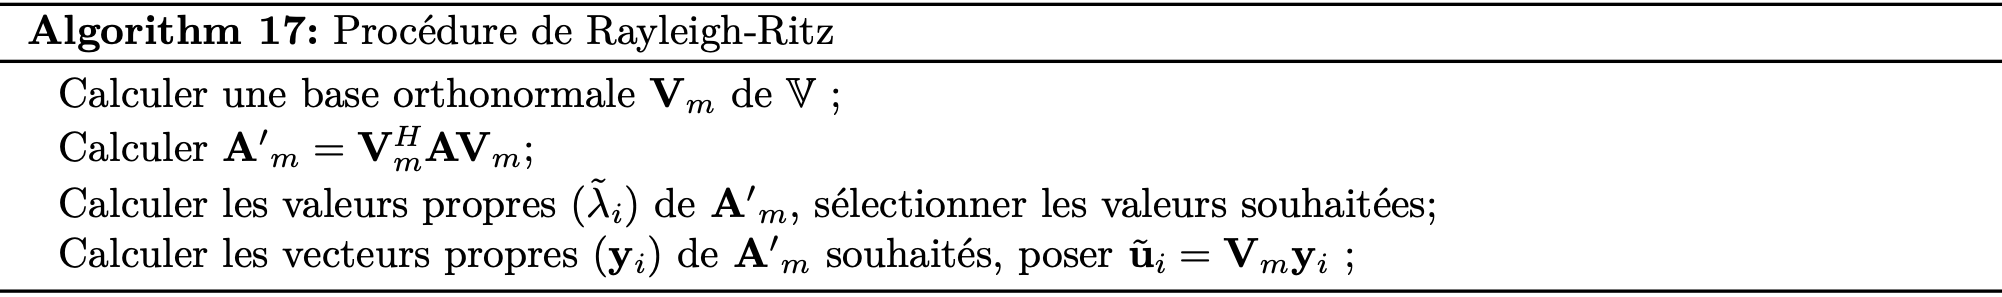

Dans le cas Hermitien les éléments propres obtenus par la procédure de
Rayleigh-Ritz sont optimaux dans un certain sens.

Dans la cas d'une projection en minimum de résidu
$({\mathbf{W}}={\mathbf{A}}{\mathbf{V}})$,
on parle des vecteurs Ritz harmoniques, le problème aux valeurs propres
projeté s'écrit : $$\begin{aligned}
\tilde{{\mathbf{u}}}&={\mathbf{V}}{\mathbf{y}} \\
\left({\mathbf{V}}^T{\mathbf{A}}^T{\mathbf{A}}{\mathbf{V}}\right){\mathbf{y}}&=\tilde{\lambda}\left({\mathbf{V}}^T{\mathbf{A}}^T{\mathbf{V}}\right){\mathbf{y}} \\
\left({\mathbf{V}}^T{\mathbf{A}}^T{\mathbf{A}}{\mathbf{V}}\right){\mathbf{y}}&=\tilde{\lambda}\left({\mathbf{V}}^T{\mathbf{A}}^T{\mathbf{A}}^{-1}{\mathbf{A}}{\mathbf{V}}\right){\mathbf{y}} \\
\end{aligned}$$ 

On reconnaît une méthode de Rayleigh-Ritz sur la matrice
inverse projetée dans le sous-espace
${\mathbf{A}}{\mathbf{V}}$.